In [9]:
using NBInclude

@nbinclude("functions.ipynb")

All function imported


In [11]:
function get_test_loader(batch_size, shuffle::Bool)
    # The FashionMNIST test set is made up of 10k 28 by 28 greyscale images
    test_x, test_y = MNIST.testdata(Float32)
    test_x = 1 .- reshape(test_x, (784, :))
    return DataLoader((test_x, test_y), batchsize=batch_size, shuffle=shuffle)
end

function load_model_sep(load_dir::String, epoch::Int)
    print("Loading model...")
    @load joinpath(load_dir, "model-$epoch.bson") encoder_μ encoder_logvar W1 W2 W3 Q
    println("Done")
    return encoder_μ, encoder_logvar, W1, W2, W3, Q
end

function load_model_identity(load_dir::String, epoch::Int)
    print("Loading model...")
    @load joinpath(load_dir, "model-$epoch.bson") encoder_μ encoder_logvar decoder decoder_last
    println("Done")
    return encoder_μ, encoder_logvar, decoder, decoder_last
    
end

# setup
# experiments with MNIST dataset
x_dim = 784
k = 20

tolerance = 1e-7; max_iter = 6000; out_toggle = 0
trials = 10
opt = Flux.Optimise.ADAM(.1);

# encoder_μ_inco, encoder_logvar_inco,  W1_inco, W2_inco, W3_inco, Q_inco = load_model_sep("trained_GNN/MNIST_identity_v4", 25)
B = randn(x_dim, 500)/sqrt(x_dim)
_, _,  W1_co, W2_co, W3_co, Q_co = load_model_sep("trained_GNN/MNIST_v2", 25)
F = dct(diagm(ones(x_dim)),2);
β_list, α_list = get_β_α(F, Q_co, B, 20);
recovery_error_matrix = zeros(trials, 1 + length(β_list) )
recon_error_matrix = zeros(trials, 1 + length(β_list) );

m_list = 20:20:400

Loading model...Done

20:20:400

In [12]:
length(m_list)
α_list

W1_rand = randn(500, 20)/sqrt(500)
W2_rand = randn(500,500)/sqrt(500)
z = randn(k); norm(z)



4.969220128394081

In [13]:
phase_matrix_recovery = zeros(trials, length(m_list), length(β_list))
phase_matrix_recon = zeros(trials, length(m_list), length(β_list))


Threads.@threads for i in 1:length(m_list)
    m = m_list[i]
    recovery_error_matrix = zeros(trials)
    recon_error_matrix = zeros(trials)
    for β in β_list
        recovery_error_list = []
        recon_error_list = []
        G = Chain(
            Dense(20, 500, relu, bias = false; init =(out,in) ->  W1_rand),
            Dense(500, 500, relu, bias = false; init =(out,in) -> W2_rand),
            Dense(500, 784, identity, bias = false; init =(out,in) -> β * Q_co + (1-β)*B),
        )      #setup the generative network 

        for trials in 1:trials
            F_sub = sample_fourier(m, x_dim)  # subsampling DCT for measurement matrix
            F_sub = F_sub * sqrt(x_dim)/sqrt(m) #normalization          
            y = F_sub * G(z) # measurement vector using subsampled DCT matrix

            z_est = randn(k) #initialization for algorithm
            z_est = estimated_code(opt, G, y, F_sub, z_est; max_iter, tolerance, out_toggle)  # run a optimizer to solve the least squares problem

            push!(recovery_error_list, relative_error(z, z_est))    
            push!(recon_error_list, relative_error(G(z), G(z_est)))
        end

        recovery_error_matrix =  hcat(recovery_error_matrix, recovery_error_list)
        recon_error_matrix = hcat(recon_error_matrix, recon_error_list)
    end
    phase_matrix_recovery[:, i, :] = recovery_error_matrix[:, 2:end]
    phase_matrix_recon[:, i, :] = recon_error_matrix[:, 2:end]
    println("Done with m = $m")
println("")
end



In [ ]:
save("saved_data/Phase_plot_MNIST_paper_v3.jld", "phase_matrix_recovery", phase_matrix_recovery, "phase_matrix_recon", phase_matrix_recon, "α_list", α_list, "m_list", m_list, "trials", trials)

In [7]:
M = zeros(size(phase_matrix_recovery[1,:,:]))
for trial in 1:trials
    M += (phase_matrix_recovery[trial,:,:] .< 1e-2)
end


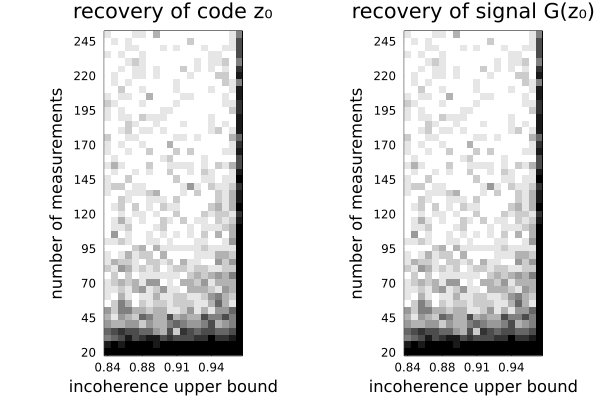

In [8]:
M = zeros(size(phase_matrix_recovery[1,:,:]))
for trial in 1:trials
    M += (phase_matrix_recovery[trial,:,:] .< 1e-5)
end
p1 = plot(colorview(Gray, reverse(M/trials, dims = 1)), bg =:black, title = "recovery of code z₀", framestyle = :box)
xticks = 1:5:length(α_list)
xticks!(xticks, ["$(round.(α_list, digits = 2)[i])" for i in 1:5:length(α_list)])
yticks = 2:5:length(m_list)
yticks!(yticks, ["$(m_list[length(m_list) + 1 - i])" for i in 2:5:length(m_list)])


M = zeros(size(phase_matrix_recon[1,:,:]))
for trial in 1:trials
    M += (phase_matrix_recovery[trial,:,:] .< 1e-5)
end

p2 = plot(colorview(Gray, reverse(M/trials, dims = 1)), bg =:black, title = "recovery of signal G(z₀)",framestyle = :box)
xticks = 1:5:length(α_list)
xticks!(xticks, ["$(round.(α_list, digits = 2)[i])" for i in 1:5:length(α_list)])
yticks = 2:5:length(m_list)
yticks!(yticks, ["$(m_list[length(m_list) + 1 - i])" for i in 2:5:length(m_list)])
# plot!(1:length(α_list), ff.(m_pred), label =:false, linewidth = 2 )

plot(p1, p2, layout = 2, xlabel = "incoherence upper bound", ylabel = "number of measurements")
# savefig("figures/Phase_MNIST_paper.pdf")



In [95]:


M = sum(phase_matrix_recovery,dims =1)[1,:,:]/20; M[M .>1] .= 1
p1 = plot(colorview(Gray, reverse(M,dims=1)), framestyle = :box, bg =:black, title = "recovery of code z₀")
xticks = 1:5:length(α_list)
xticks!(xticks, ["$(round.(α_list, digits = 2)[i])" for i in 1:5:length(α_list)])
yticks = 2:5:length(m_list)
yticks!(yticks, ["$(m_list[length(m_list) + 1 - i])" for i in 2:5:length(m_list)])

M = sum(phase_matrix_recon,dims =1)[1,:,:]/20; M[M .>1] .= 1
p2 = plot(colorview(Gray, reverse(M,dims=1)), framestyle = :box, bg =:black, title = "recovery of signal G(z₀)")
xticks = 1:5:length(α_list)
xticks!(xticks, ["$(round.(α_list, digits = 2)[i])" for i in 1:5:length(α_list)])
yticks = 2:5:length(m_list)
yticks!(yticks, ["$(m_list[length(m_list) + 1 - i])" for i in 2:5:length(m_list)])

plot(p1, p2, layout = 2,  bg =:white)
savefig("figures/Phase_plot_Full_MNIST_error.pdf")

